In [1]:
import scipy.io
import numpy as np
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import time as ktime
from sklearn.preprocessing import StandardScaler, normalize, scale
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
def dict_fixer(result, test=True):
    """ Result is a dicitonary """
    if test:
        result['test_errors'] = result.pop('test_error').squeeze().numpy()
        result['test_label'] = result.pop('test_label').numpy()
        result['test_pred'] = result.pop('test_pred').squeeze().numpy()

    result['val_preds'] = result.pop('preds')
    result['val_labels'] = result.pop('labels')
    result['val_errors'] = result.pop('errors')

    return result

In [3]:
ff = np.load("./old_results/fc_l1_0_3000_data.npy", allow_pickle=True).item()
ff.keys()

dict_keys(['train_loss', 'test_loss', 'val_loss', 'min_loss', 'preds', 'labels', 'errors', 'params'])

In [117]:
ff = np.load("fc_huber_0_5000_data.npy", allow_pickle=True).item()
ff.keys()

dict_keys(['train_loss', 'test_loss', 'val_loss', 'min_loss', 'preds', 'labels', 'errors', 'params'])

In [188]:
ff = np.load("fc_huber_test_0_5000_data.npy", allow_pickle=True).item()
print(ff.keys())
print(ff['train_loss'].shape,  ff['test_pred'].shape, ff['test_label'].shape, ff['test_error'].shape, ff['val_loss'].shape, ff['preds'].shape, ff['labels'].shape,ff['errors'].shape, )

dict_keys(['train_loss', 'test_loss', 'test_pred', 'test_label', 'test_error', 'val_loss', 'min_loss', 'preds', 'labels', 'errors', 'params'])
(3003,) torch.Size([2400, 1]) torch.Size([2400]) torch.Size([2400, 1]) (3003,) (21621600,) (21621600,) (21621600,)


In [189]:
# fix old files
isNew = True
ff = dict_fixer(ff, test=isNew)
ff.keys()
if isNew:
    print(ff['train_loss'].shape, ff['val_loss'].shape, ff['val_preds'].shape, ff['val_labels'].shape,ff['val_errors'].shape, ff['test_pred'].shape, ff['test_label'].shape, ff['test_errors'].shape)
else:
        print(ff['train_loss'].shape, ff['val_loss'].shape, ff['val_preds'].shape, ff['val_labels'].shape,ff['val_errors'].shape,) # ff['test_pred'].shape, ff['test_label'].shape, ff['test_errors'].shape)

(3003,) (3003,) (21621600,) (21621600,) (21621600,) (2400,) (2400,) (2400,)


In [61]:
fp = np.load("./results_time/tCNN_l2_0_2000_data.npy", allow_pickle=True).item()

print(fp.keys())
#print(fp['train_loss'].shape,  ff['test_pred'].shape, ff['test_label'].shape, ff['test_errors'].shape, ff['val_loss'].shape, ff['val_preds'].shape, ff['val_labels'].shape,ff['val_errors'].shape, )

dict_keys(['train_loss', 'test_loss', 'test_pred', 'test_label', 'test_errors', 'val_loss', 'min_loss', 'val_preds', 'val_labels', 'val_errors', 'params'])


In [279]:
ff = np.load("./results_time/FC_hu_4i_0_1000_data.npy", allow_pickle=True).item()
print(ff.keys())
print(ff['train_loss'].shape,  ff['test_pred'].shape, ff['test_label'].shape, ff['test_errors'].shape, ff['val_loss'].shape, ff['val_preds'].shape, ff['val_labels'].shape,ff['val_errors'].shape, )

dict_keys(['train_loss', 'test_loss', 'test_pred', 'test_label', 'test_errors', 'val_loss', 'min_loss', 'val_preds', 'val_labels', 'val_errors', 'params'])
(1000,) (2400,) (2400,) (2400,) (1000,) (7200000,) (7200000,) (7200000,)


In [265]:
# test data
ff = np.load("./results_time/lstm_4i_384_testData.npy", allow_pickle=True).item()

print(ff.keys())
print(  ff['test_pred'].shape, ff['test_label'].shape, ff['test_errors'].shape,)

dict_keys(['test_loss', 'test_pred', 'test_label', 'test_errors'])
(2392,) (2392,) (2392,)


<h2>Questions to ask</h2>
<ol>
<li>what should be the length of prediciton? 1 ?</li>
<li></li>
</ol>

In [167]:
mat = scipy.io.loadmat('Data_Ankle.mat')['ankle_data']
mat.shape

In [169]:
mat=scale(mat, axis=0)

In [11]:
#
for i in range(mat.shape[1]):
    plt.figure(i,figsize=(18,5))
    plt.subplot(1,2,1)
    plt.plot(scale(mat[:,i])[4500:5000])
    #plt.subplot(1,3,2)
    #plt.plot(normalize(mat[:,1])[:500])
    plt.subplot(1,2,2)
    plt.plot(mat[:,i][4500:5000])


NameError: name 'mat' is not defined

In [20]:
ff["params"]

'lstm model, Adam, lr=0.001, b=50, L1 loss'

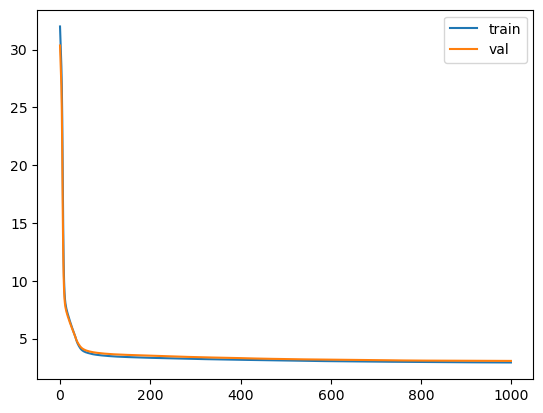

In [270]:
plt.plot(ff['train_loss'], label='train')
plt.plot(ff['val_loss'], label="val")
#plt.yscale("log")
plt.legend()


In [260]:
print(np.argmin(ff['val_loss']),np.min(ff['val_loss']))
print(np.argmin(ff['train_loss']),np.min(ff['train_loss']))

385 2.286300551146269
986 1.7689869134919718


In [40]:
torch.max(-ff['test_label'][1900:2400])

TypeError: max(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [280]:
# Analyse Test Data
preds = ff['test_pred'].squeeze()
labels = ff['test_label']
# positive peaks
pp = 20
#pred_peaks = scipy.signal.find_peaks(preds, prominence=pp, distance=50)
label_peaks = scipy.signal.find_peaks(labels, prominence=pp, distance=50)
# negative peaks
neg_pp = 1 #2
neg_label_peaks = scipy.signal.find_peaks(-labels, height=neg_pp, distance=10 )
#neg_pred_peaks = scipy.signal.find_peaks(-preds, height=neg_pp, )
#
print( label_peaks[0].shape, neg_label_peaks[0].shape)
# correlation
#print("positive corr: \n", np.corrcoef(pred_peaks[0],label_peaks[0]),  "\nnegative corr: \n", np.corrcoef(neg_pred_peaks[0], neg_label_peaks[0]))
#np.corrcoef(neg_pred_peaks[0][:len(neg_label_peaks[0])], neg_label_peaks[0])

(26,) (62,)


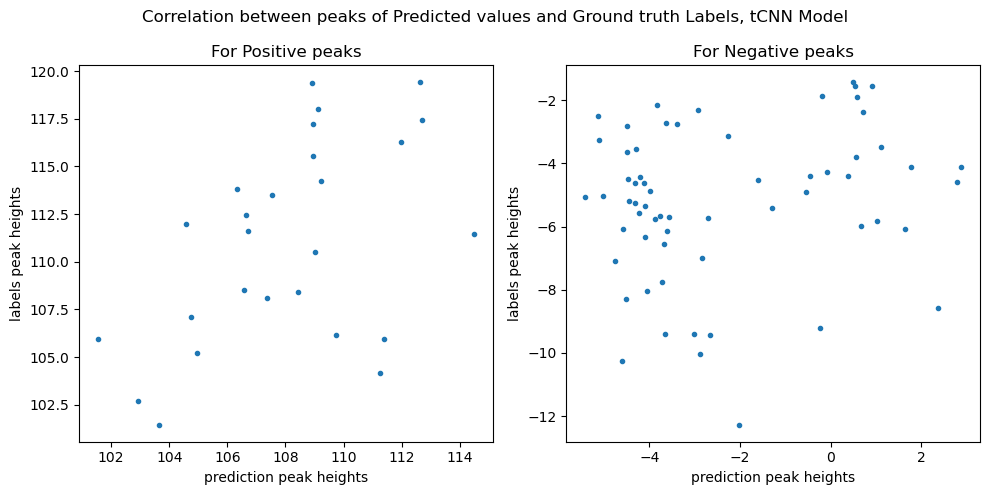

In [281]:
# Find peaks of labels, and corresponding values of prediciton
plt.figure(figsize=(10,5))
plt.suptitle("Correlation between peaks of Predicted values and Ground truth Labels, tCNN Model")
plt.subplot(1,2,1)
plt.plot(preds[label_peaks[0]],labels[label_peaks[0]], linestyle='', marker='.')
plt.xlabel("prediction peak heights")
plt.ylabel("labels peak heights")
plt.title("For Positive peaks")
plt.subplot(1,2,2)
plt.plot(preds[neg_label_peaks[0]],labels[neg_label_peaks[0]], linestyle='', marker='.')
plt.xlabel("prediction peak heights")
plt.ylabel("labels peak heights")
plt.title("For Negative peaks")

plt.tight_layout()

In [283]:
pearsonr(preds[label_peaks[0]],labels[label_peaks[0]])

PearsonRResult(statistic=0.5007306224920162, pvalue=0.00917496665339853)

In [274]:
pearsonr(preds[neg_label_peaks[0]],labels[neg_label_peaks[0]])

PearsonRResult(statistic=0.18665066268625533, pvalue=0.14634073859899366)

In [11]:
mean_squared_error(labels[label_peaks[0]],preds[label_peaks[0]] )

36.158085

In [85]:
np.corrcoef(preds[label_peaks[0]],labels[label_peaks[0]])

array([[1.        , 0.86592521],
       [0.86592521, 1.        ]])

In [16]:
np.corrcoef(preds[neg_label_peaks[0]],labels[neg_label_peaks[0]])

array([[1.        , 0.19918133],
       [0.19918133, 1.        ]])

In [25]:
preds = ff['val_preds']
labels = ff['val_labels']
# positive peaks
pp = 10
#val_pred_peaks = scipy.signal.find_peaks(preds, prominence=pp, distance=50)
#val_label_peaks = scipy.signal.find_peaks(labels, prominence=pp, distance=50)
# negative peaks
neg_pp = 5
#val_neg_label_peaks = scipy.signal.find_peaks(-labels, prominence=neg_pp, distance=40)
#val_neg_pred_peaks = scipy.signal.find_peaks(-preds, prominence=neg_pp, distance=40)
#
# print(val_pred_peaks[0].shape, val_label_peaks[0].shape, val_neg_pred_peaks[0].shape, val_neg_label_peaks[0].shape)
# correlation
# print("positive corr: \n", np.corrcoef(pred_peaks[0],label_peaks[0]),  "\nnegative corr: \n", np.corrcoef(neg_pred_peaks[0], neg_label_peaks[0]))
#np.corrcoef(neg_pred_peaks[0][:len(neg_label_peaks[0])], neg_label_peaks[0])

KeyError: 'val_preds'

In [336]:
# FC
fp = np.load("./results/FC_L2_0_10000_data.npy", allow_pickle=True).item()    ## L2
fs = np.load("./results/FC_L1_0_5000_data.npy", allow_pickle=True).item()        ## L1
ff = np.load("./results/FC_Hu_0_5000_data.npy", allow_pickle=True).item()           ## Huber
# ff = np.load("./results/tCNN_132_testData.npy", allow_pickle=True).item()

In [200]:
# TCNN
fp = np.load("./results_time/tCNN_l2_0_2000_data.npy", allow_pickle=True).item()    ## L2
fs = np.load("./results_time/tCNN_l1_0_1000_data.npy", allow_pickle=True).item()        ## L1
ff = np.load("./results/tCNN_132_testData.npy", allow_pickle=True).item()   ## Huber

In [199]:
# LSTM
fp = np.load("./results_time/lstm_l2_1000_2000_data.npy", allow_pickle=True).item()    ## L2
fs = np.load("./results_time/lstm_l1_1000_2000_data.npy", allow_pickle=True).item()        ## L1
ff = np.load("./results_time/lstm_hu_0_2000_data.npy", allow_pickle=True).item()   ## Huber

In [329]:
#combo
ff = np.load("./results_time/lstm_hu_0_2000_data.npy", allow_pickle=True).item()   ## Huber
fp = np.load("./results/tCNN_132_testData.npy", allow_pickle=True).item()  #CNN
fs = np.load("./results/FC_Hu_0_5000_data.npy", allow_pickle=True).item() 

In [314]:
# combo 4i
ff = np.load("./results_time/lstm_4i_384_testData.npy", allow_pickle=True).item()  ## LSTM
fp = np.load("./results_time/tCNN_hu_4i_200_testData.npy", allow_pickle=True).item()  #CNN
fs = np.load("./results_time/FC_hu_4i_0_1000_data.npy", allow_pickle=True).item()  # FC

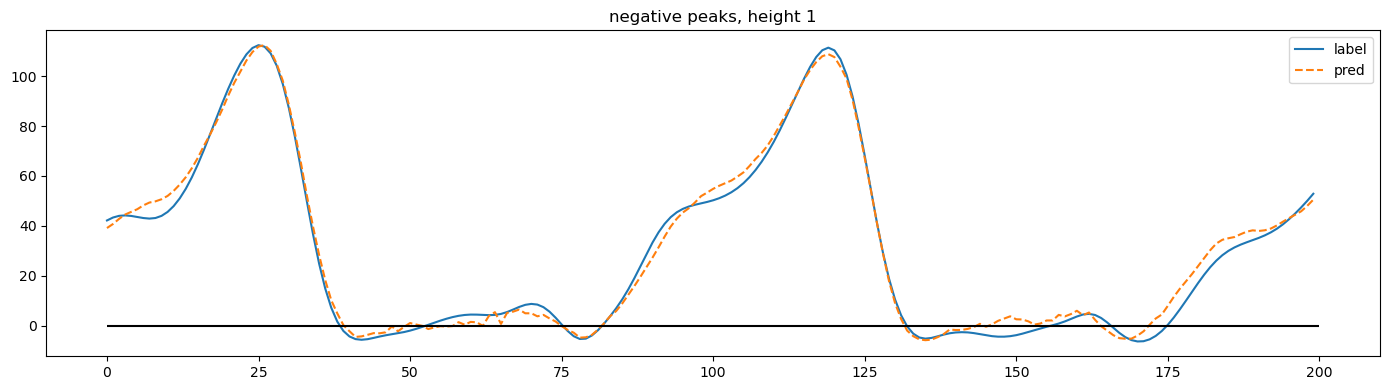

In [332]:
# Analyze Test Data
pp = 10
neg_pp = 1
#val_n = 7200 #25*50 #113*64
#epoch_n = val_n*2700   # 1979
#epoch_n2 = val_n*2700
i, T = 1000,1200
tt = np.arange(i,T,1)
preds = ff['test_pred'][i:T]
labels = ff['test_label'][i:T]
#pred_peaks = scipy.signal.find_peaks(preds, prominence=pp, distance=50)
label_peaks = scipy.signal.find_peaks(labels, prominence=pp,distance=50 )
#neg_pred_peaks = scipy.signal.find_peaks(-preds, height=neg_pp, distance=5)
neg_label_peaks = scipy.signal.find_peaks(-labels, height=neg_pp, distance=10)
#print(pred_peaks[0].shape, label_peaks[0].shape, neg_pred_peaks[0].shape, neg_label_peaks[0].shape )
#plot
plt.figure(figsize=(14,4))
plt.plot(labels, label='label',  )
#plt.plot(ff['errors'][epoch_n+i:epoch_n+T], label ='erors')#
plt.plot(preds, label ='pred', linestyle='--',)#
plt.hlines([0], 0, T-i, color='black')
# pos peaks
#plt.vlines(label_peaks[0], np.min(preds), np.max(preds),linewidth=1, color='r', label="label_pos_peaks")
#plt.vlines(pred_peaks[0], np.min(preds), np.max(preds),linewidth=1, color='black', label="pred_pos_peaks")
# neg peaks
#plt.vlines(neg_label_peaks[0], np.min(preds), np.max(preds),linewidth=1, color='r', label="label_neg_peaks")
#plt.vlines(neg_pred_peaks[0], np.min(preds), np.max(preds),linewidth=1, color='black', label="pred_neg_peaks")
plt.title("negative peaks, height 1")
plt.legend()
plt.tight_layout()

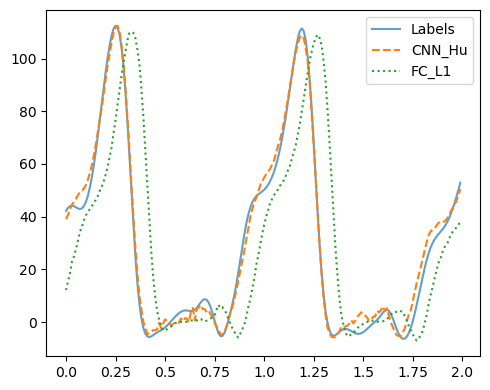

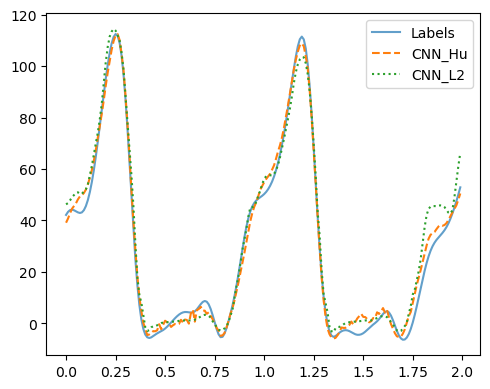

In [333]:
# continued from above

preds2 = fp['test_pred'][i:T]    #L2 #cnn
preds3 = fs['test_pred'][i:T]   # L1  # fc
#label_peaks2 = scipy.signal.find_peaks(labels2, prominence=pp,distance=50 )
#neg_label_peaks2 = scipy.signal.find_peaks(-labels2, height=neg_pp, distance=10)
plt.figure(figsize=(5,4))
plt.plot(labels, label='Labels', alpha=0.7 )
plt.plot(preds, label ='CNN_Hu', linestyle='dashed', )
# plt.plot(preds2, label ='FC_L2', linestyle='dashed', )#
plt.plot(preds3, label ='FC_L1', linestyle='dotted', )#
# plt.xlabel("Time in Seconds")
# plt.ylabel("Ankle Joint Moment in Nm")
plt.xticks(np.arange(0, 201, 25), np.linspace(0,2,9) )
plt.legend()
plt.tight_layout()
plt.figure(figsize=(5,4))
plt.plot(labels, label='Labels', alpha=0.7 )
plt.plot(preds, label ='CNN_Hu', linestyle='dashed', )
plt.plot(preds2, label ='CNN_L2', linestyle='dotted', )#
# plt.plot(preds3, label ='FC_L1', linestyle='dotted', )#
plt.xticks(np.arange(0, 201, 25), np.linspace(0,2,9) )
# plt.xlabel("Time in Seconds")
# plt.ylabel("Ankle Joint Moment in Nm")
plt.legend()
plt.tight_layout()

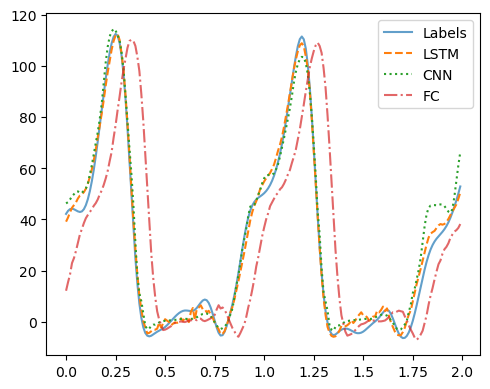

In [334]:
plt.figure(figsize=(5,4))
plt.plot(labels, label='Labels', alpha=0.7 )
plt.plot(preds, label ='LSTM', linestyle='dashed', )
plt.plot(preds2, label ='CNN', linestyle='dotted', )#
plt.plot(preds3, label ='FC', linestyle='dashdot', alpha=0.7 )#
plt.xticks(np.arange(0, 201, 25), np.linspace(0,2,9) )
plt.legend()
plt.tight_layout()

In [337]:
# Analyse Test Data
preds = ff['test_pred'].squeeze()
preds2 = fs['test_pred'].squeeze()  # L1
preds3 = fp['test_pred'].squeeze()  # L2
labels = ff['test_label']
# positive peaks
pp = 20
label_peaks = scipy.signal.find_peaks(labels, prominence=pp, distance=50)
# negative peaks
neg_pp = 1 #2
neg_label_peaks = scipy.signal.find_peaks(-labels, height=neg_pp, distance=10 )


print("Huber, lstm: ", pearsonr(preds[label_peaks[0]],labels[label_peaks[0]])[0],",",pearsonr(preds[neg_label_peaks[0]],labels[neg_label_peaks[0]])[0])
print("L1:, fc ", pearsonr(preds2[label_peaks[0]],labels[label_peaks[0]])[0],",",pearsonr(preds2[neg_label_peaks[0]],labels[neg_label_peaks[0]])[0])
print("L2:, cnn ", pearsonr(preds3[label_peaks[0]],labels[label_peaks[0]])[0],",",pearsonr(preds3[neg_label_peaks[0]],labels[neg_label_peaks[0]])[0])

Huber, lstm:  0.6960270886188973 , 0.36602134878037496
L1:, fc  0.721955430544676 , 0.36097231349780257
L2:, cnn  0.6972509173548463 , 0.3979052604944569


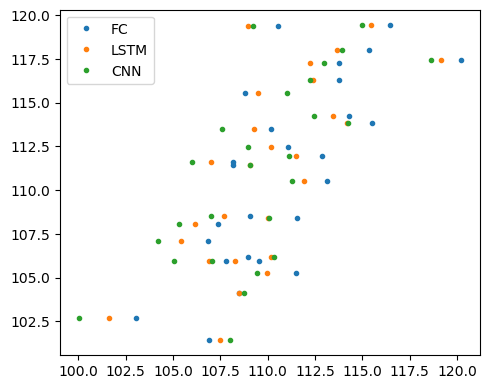

In [338]:
plt.figure(figsize=(5,4))
plt.plot(preds2[label_peaks[0]],labels[label_peaks[0]], linestyle='', marker='.', label ='FC')
plt.plot(preds[label_peaks[0]],labels[label_peaks[0]], linestyle='', marker='.', label ='LSTM' )
plt.plot(preds3[label_peaks[0]],labels[label_peaks[0]], linestyle='', marker='.', label ='CNN')
plt.legend()
plt.tight_layout()

In [ ]:
y = [preds[label_peaks[0]],(1,1,2,4)]
x = [1,2]

for xe, ye in zip(x, y):
    plt.scatter([xe] * len(ye), ye)

(6,) (6,) (5,) (5,) -6.02461051940918
[ 27 121 214 303 398 488] [ 25 121 214 303 397 487]
{'peak_heights': array([104.26672363, 109.89006805, 109.79554749, 107.82460785,
       109.29506683, 109.11480713])} {'peak_heights': array([108.56773376, 113.52898407, 109.71581268, 104.62624359,
       110.36257172, 117.69316864])}


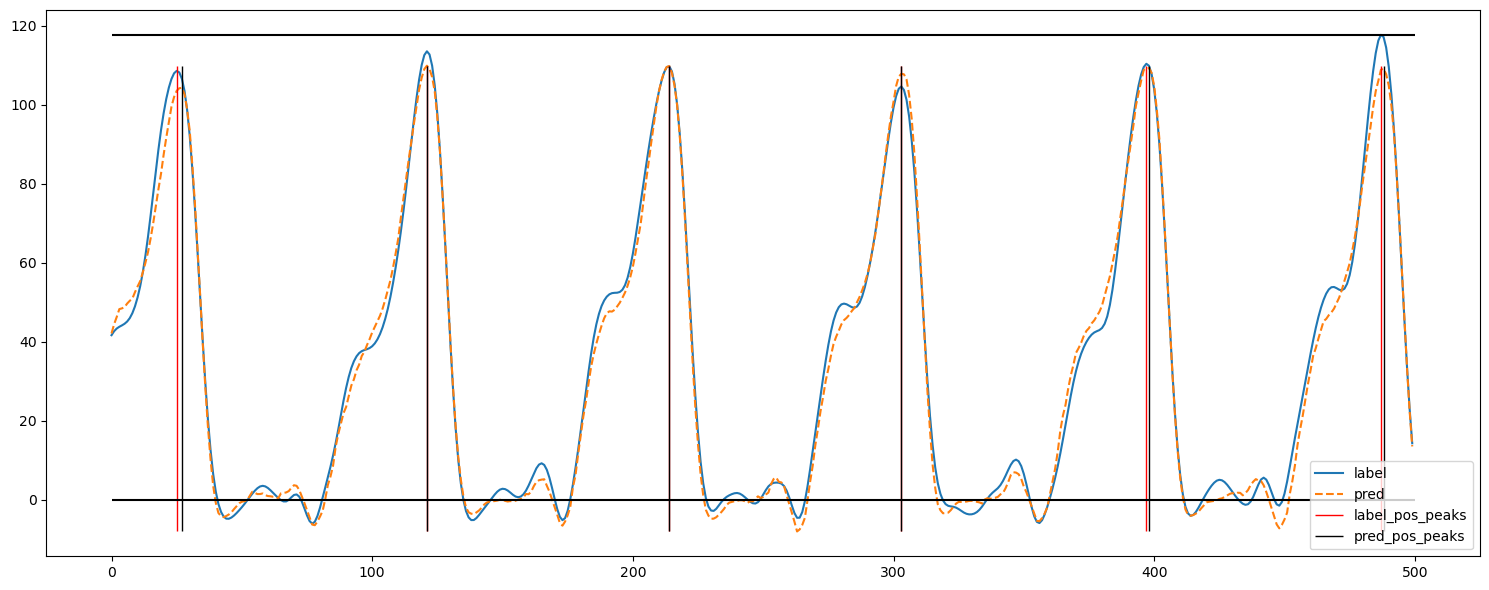

In [26]:

pp = 30
neg_pp = 4
val_n = 7200 #25*50 #113*64
epoch_n = val_n*1002   # 1979
epoch_n2 = val_n*1002
i, T = 6000,6500
tt = np.arange(epoch_n+i, epoch_n+T,1)
preds = ff['val_preds'][epoch_n+i : epoch_n2+T]
labels = ff['val_labels'][epoch_n+i: epoch_n2+T]
pred_peaks = scipy.signal.find_peaks(preds, height=pp, distance=50)
neg_pred_peaks = scipy.signal.find_peaks(-preds, height=neg_pp, distance=50)
label_peaks = scipy.signal.find_peaks(labels, height=pp, distance=40)
neg_label_peaks = scipy.signal.find_peaks(-labels, height=neg_pp, distance=40)
print(pred_peaks[0].shape, label_peaks[0].shape, neg_pred_peaks[0].shape, neg_label_peaks[0].shape, -np.max(-labels) )
print(pred_peaks[0], label_peaks[0])
print(pred_peaks[1], label_peaks[1])
plt.figure(figsize=(15,6))
plt.plot(labels, label='label',  )
#plt.plot(ff['errors'][epoch_n+i:epoch_n+T], label ='erors')#
plt.plot(preds, label ='pred', linestyle='--',)#
# pos peaks
plt.vlines(label_peaks[0], np.min(preds), np.max(preds),linewidth=1, color='r', label="label_pos_peaks")
plt.vlines(pred_peaks[0], np.min(preds), np.max(preds),linewidth=1, color='black', label="pred_pos_peaks")
plt.hlines([0, np.max(labels)], 0, T-i, color='black')
# neg peaks
#plt.vlines(neg_label_peaks[0], np.min(preds), np.max(preds),linewidth=1, color='r', label="label_neg_peaks")
#plt.vlines(neg_pred_peaks[0], np.min(preds), np.max(preds),linewidth=1, color='black', label="pred_neg_peaks")
#plt.hlines([0, -np.max(-labels)], 0, T-i, color='black')
plt.legend()
plt.tight_layout()


In [3]:
data = pd.DataFrame(mat)
data.columns = ['time','ground-reaction(N)','trunk-angle(rad)','hip-angle(rad)','knee-angle(rad)','ankle-angle(rad)','joint-moment(Nm)']
data.head()

,time,ground-reaction(N),trunk-angle(rad),hip-angle(rad),knee-angle(rad),ankle-angle(rad),joint-moment(Nm)
0,0.00,-10.321381,-0.094286,0.292974,0.825063,-1.492588,-2.011628
1,0.01,-7.990312,-0.096174,0.293179,0.822469,-1.493192,-3.655209
2,0.02,-6.208738,-0.096449,0.294008,0.810997,-1.495867,-5.786433
3,0.03,-5.126637,-0.097196,0.295568,0.785731,-1.501793,-6.190008
4,0.04,-4.774037,-0.095624,0.297472,0.745707,-1.511208,-5.542868


In [4]:
data_np = mat[:1000,:]
data_np.shape

(1000, 7)

In [5]:
epoch_n = len(data_np)
th = int(0.8*epoch_n)
vh = int(0.9*epoch_n)
td = data_np[:th,:]
vd = data_np[th:vh, :]
tsd = data_np[vh:,:]
print(epoch_n,th,vh,len(td),len(vd),len(tsd))

1000 800 900 800 100 100


In [31]:
td[:,:-1].shape

(38400, 6)

In [6]:
def split_sequences(seq, n_steps_in, n_steps_out):
    input_sequences, output_sequence = seq[:,:], seq[:,-1]
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

In [7]:
steps_in = 10
steps_out = 1
tr_d, tr_l = split_sequences(td, n_steps_in=steps_in, n_steps_out=steps_out)
print(tr_d.shape, tr_l.shape)

(791, 10, 7) (791, 1)


In [8]:
xx,yy = split_sequences(data_np, n_steps_in=10, n_steps_out=1)
xx.shape, yy.shape

((991, 10, 7), (991, 1))

In [10]:
#train_data, test_data = train_test_split(xx, test_size=0.2, random_state=1)
#train_label, test_label = train_test_split(yy, test_size=0.2, random_state=1)
#train_data, train_labels= split_sequences(td, 200, 1)
#test_data, test_labels= split_sequences(tsd, 100, 1)
train_batches = torch.utils.data.DataLoader(LeggedMotion_seq_dataset(data=td), batch_size=100,  num_workers=4, shuffle=False)
test_batches = torch.utils.data.DataLoader(LeggedMotion_seq_dataset(data=vd), batch_size=100,  num_workers=4, shuffle=False)
print(f'len of trainBatches:{len(train_batches)}, testBatches-{len(test_batches)} , ')

len of trainBatches:8, testBatches-1 , 


In [21]:
batch_size = 50
USE_CUDA = False#torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor


In [19]:
from utils.model import FC_model

fcmodel = FC_model()

In [17]:
torch.cuda.empty_cache()

In [22]:
model = fcmodel.type(dtype)
optim = torch.optim.Adam(model.parameters(),lr=0.0001)
lss = nn.MSELoss().type(dtype)

epochs = 1000
losst = []
lossv = []
st = ktime.time()
for i in range(epochs):

    
    # fit loop
    lossTrain = 0
    lossVal = 0
    model.train()
    if USE_CUDA:
            torch.cuda.empty_cache()
    c = 0
    for idx, batches in enumerate(train_batches):
        #
        #feat, labe = batches
        time, ground_reac, trunk_j, hip_j, knee_j, ankle_j, joint_moment = batches
        # ground_reac = ground_reac.type(dtype).unsqueeze(1)
        # trunk_j = trunk_j.type(dtype).unsqueeze(1)
        # hip_j = hip_j.type(dtype).unsqueeze(1)
        # knee_j = knee_j.type(dtype).unsqueeze(1)
        # ankle_j = ankle_j.type(dtype).unsqueeze(1)
        #joint_moment = joint_moment
        #
        #print(feat.size(), labe.size())
        #print(hip_j.size(), joint_moment.size())
        optim.zero_grad()
        #inp = torch.hstack((trunk_j, hip_j, knee_j, ankle_j)).unsqueeze(2)
        #inp = torch.cat((trunk_j, hip_j, knee_j.unsqueeze(1), ankle_j.unsqueeze(1)), dim=1)
        
        inp = torch.cat((ground_reac.unsqueeze(1),trunk_j.unsqueeze(1),hip_j.unsqueeze(1),knee_j.unsqueeze(1),ankle_j.unsqueeze(1)), dim=1).type(dtype)
        #print(inp.size(), trunk_j.size())
        #inp = ankle_j.unsqueeze(1)
        h = model(inp)
        #h = model(ground_reac.unsqueeze(2).type(dtype))
        l = lss(h, joint_moment.type(dtype))
        l.backward()
        optim.step()
        lossTrain += l.detach().item()
        c += 1
        if c == 2:
            pass
            #print("intrain", h.size(), inp.size(), joint_moment.size())
            #break
        
    # # validation 
    model.eval()
    with torch.no_grad():
        for idx, batches in enumerate(test_batches):
            #
            time, ground_reac, trunk_j, hip_j, knee_j, ankle_j, joint_moment = batches
            # ground_reac = ground_reac.type(dtype).unsqueeze(1)
            # trunk_j = trunk_j.type(dtype).unsqueeze(1)
            # hip_j = hip_j.type(dtype).unsqueeze(1)
            # knee_j = knee_j.type(dtype).unsqueeze(1)
            # ankle_j = ankle_j.type(dtype).unsqueeze(1)
            #joint_moment = joint_moment
            #
            #inp = torch.hstack((trunk_j, hip_j, knee_j, ankle_j)).unsqueeze(1)
            inp = torch.cat((ground_reac.unsqueeze(1),trunk_j.unsqueeze(1),hip_j.unsqueeze(1),knee_j.unsqueeze(1),ankle_j.unsqueeze(1)), dim=1).type(dtype)
            #inp = ankle_j.unsqueeze(1)
            h = model(inp)
            l = lss(h, joint_moment.type(dtype))
            lossVal += l.detach().item()


    # 
    avgLoss_t = lossTrain/train_batches.__len__()
    avgLoss_v = lossVal/test_batches.__len__()
    losst.append(avgLoss_t)
    lossv.append(avgLoss_v)
    if i%100 == 0:
        print(f'trainLoss: {avgLoss_t:.2f} and lossVal: {avgLoss_v:.2f} at epoch-{i} with time:{ktime.time()-st}')
        st = ktime.time()

plt.figure()
plt.plot(losst, label='train')
plt.plot(lossv, label='test')
plt.legend()
    

/home/jeet/anaconda3/envs/mpa/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


trainLoss: 2248.22 and lossVal: 1608.57 at epoch-0 with time:1.178467035293579
trainLoss: 1575.99 and lossVal: 1277.20 at epoch-100 with time:24.04621958732605


KeyboardInterrupt: 

In [21]:
model(torch.tensor(tsd[:,1:-1]).type(dtype))

torch.Size([100, 1])

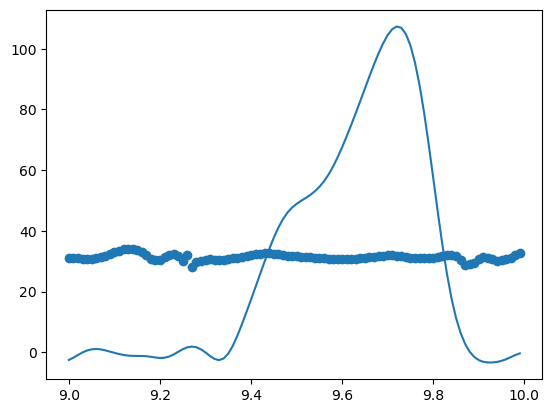

In [29]:
plt.figure()
#inp = np.cat((tsd[:,0].unsqueeze(1),trunk_j.unsqueeze(1),hip_j.unsqueeze(1),knee_j.unsqueeze(1),ankle_j.unsqueeze(1)), dim=1).type(dtype)
pred = model(torch.tensor(tsd[:,1:-1]).type(dtype))
plt.plot(tsd[:, 0],tsd[:, -1])
plt.scatter(tsd[:, 0],pred.squeeze().detach().numpy())

In [23]:
train_batches.__len__()

765

In [24]:
batch_size = 50
iters = x.shape[0]
startt = 0
endt = batch_size
bc = 0
for i in range(1):
    #    
    batch_Data = x[startt:endt].reshape(batch_size, 6, 20) # 6 is no of features
    startt += batch_size
    endt += batch_size
    bc += 1
    if endt > iters: 
        print("break: ", batch_Data.shape, endt, iters)
        break
    print(batch_Data.shape)
    #
    h = lstm(torch.Tensor(batch_Data))
    print(h.size(), h)
print("bc", bc)

NameError: name 'x' is not defined

In [ ]:
torch.hstack((torch.randn(5).unsqueeze(1), torch.randn(5).unsqueeze(1))).size()

torch.Size([5, 2])